In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from circle_fit import taubinSVD
from tqdm import tqdm
import MDAnalysis as mda
from src.utils_py.auxil import *
from scipy.optimize import minimize

/Users/alexey/Dev/CA_article/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

In [3]:
def get_center_pbc(positions, box):
    theta = positions / box * 2 * np.pi
    center = np.zeros(3)

    for i in range(3):
        phi = np.cos(theta[:, i])
        psi = np.sin(theta[:, i])

        phi_mean = np.average(phi)
        psi_mean = np.average(psi)

        theta_mean = np.arctan2(-psi_mean, -phi_mean) + np.pi
        center[i] = box[i] * theta_mean / 2 / np.pi

    return center

In [4]:
def apply_pbc(positions, box):
    half_box_size = box / 2

    ids = abs(positions - half_box_size) >= half_box_size
    positions -= np.sign(positions) * box * ids

    return positions

In [5]:
def center_residue(AtomGroup, box):
    positions = AtomGroup.copy().positions
    center = get_center_pbc(positions, box)
    positions -= center
    positions += box / 2

    return apply_pbc(positions, box)

In [6]:
def density_plane(universe, residue_name, NX, NZ, center=True, begin=0):
    u = universe.copy()
    residue = u.select_atoms(f'resname {residue_name}', updating=True)
    box = u.dimensions[:3] * 0.1 #nm
    traj = u.trajectory[begin:]
    N = len(traj)
    axis_x, dx = np.linspace(0, box[0], NX, retstep=True)
    axis_z, dz = np.linspace(0, box[2], NZ, retstep=True)
    dr = np.array([dx, dz])
    data = np.zeros((N, NX, NZ), dtype=np.float32)

    for ts in tqdm(traj):
        residue.positions *= 0.1
        if center:
            residue.positions = center_residue(residue, box)

        residue_ids = np.floor(residue.positions[:, ::2] / dr).astype(int)
        # residue_ids -= np.logical_or(residue_ids == NX, residue_ids == NZ)

        for id in residue_ids:
            data[ts.frame-begin, id[0], id[1]] += 1

    data = np.mean(data, axis=0)

    return axis_x, axis_z, data / (dx * dz * box[1]), dx, dz

In [7]:
def grid2xyz(grid, dx, dz):
    points = np.argwhere(grid > 0)

    return points * np.array(dx, dz)

In [8]:
def cropp_grid(grid):
    grid_args = np.argwhere(grid>0)
    x_min, z_min = grid_args.min(axis=0)
    x_max, z_max = grid_args.max(axis=0)
    grid_cropped = grid[x_min:x_max+1, z_min:z_max+1]

    return grid_cropped

In [9]:
def make_offset(grid, offset, dz):
    NZ = int(offset / dz)

    if NZ == 0:
        return grid, NZ

    return grid[:, NZ:-NZ], NZ

In [103]:
thetas = ['100', '110', '120', '130', '140', '150', '160', '170', '180']
types = ['roll']

In [104]:
for type in types:
    for th in thetas:
        folder = os.path.join('synthetic', th, type)

        u = mda.Universe(*[os.path.join(folder, f'{i}.gro') for i in range(1, 101)])

        grid_size = 1 # Angstrom

        NX, NY, NZ = (u.dimensions[:3] / grid_size).astype(int)

        x, z, grid, dx, dz = density_plane(u, 'POINT', NX, NZ, begin=0, center=True)

        rho_bulk = 12
        zc = 0

        grid_cropped = cropp_grid(grid)
        grid_offset, N_offset = make_offset(grid_cropped, zc, dz)

        eps = 0.2
        grid_filter = np.abs(grid_offset / rho_bulk - 0.5) < eps

        grid_xyz = grid2xyz(grid_filter, dx, dz)

        lx, lz = np.max(grid_xyz, axis=0)
        left_grid_xyz = grid_xyz[grid_xyz[:, 0] < lx / 2, :]
        right_grid_xyz = grid_xyz[grid_xyz[:, 0] > lx / 2, :]

        xc_left, zc_left, r_left, sigma_left = taubinSVD(left_grid_xyz)
        xc_right, zc_right, r_right, sigma_right = taubinSVD(right_grid_xyz)

        LX, LZ = np.array(grid_cropped.shape) * np.array([dx, dz])
        lx, lz = np.array(grid_offset.shape) * np.array([dx, dz])

        dz = N_offset * dz

        # Without extropolation
        x_top_left = -np.sqrt(r_left**2 - (lz - zc_left)**2) + xc_left
        angle_top_left = np.pi / 2 + np.arctan(np.abs(lz - zc_left) / np.abs(xc_left - x_top_left))
        x_bottom_left = -np.sqrt(r_left**2 - (zc_left)**2) + xc_left
        angle_bottom_left = np.pi / 2 + np.arctan(np.abs(zc_left) / np.abs(xc_left - x_bottom_left))

        x_top_right = np.sqrt(r_right**2 - (lz - zc_right)**2) + xc_right
        angle_top_right = np.pi / 2 + np.arctan(np.abs(lz - zc_right) / np.abs(xc_right - x_top_right))
        x_bottom_right = np.sqrt(r_left**2 - (zc_right)**2) + xc_right
        angle_bottom_right = np.pi / 2 + np.arctan(np.abs(zc_right) / np.abs(xc_right - x_bottom_right))

        print(th, np.rad2deg(angle_bottom_left + angle_top_left + angle_top_right + angle_bottom_right) / 4)

100%|██████████| 99/99 [00:02<00:00, 42.40it/s]


100 97.61277264186086


100%|██████████| 99/99 [00:02<00:00, 45.32it/s]


110 108.82975968493089


100%|██████████| 99/99 [00:02<00:00, 45.51it/s]


120 119.911944246512


100%|██████████| 99/99 [00:02<00:00, 45.71it/s]


130 130.77420652281094


100%|██████████| 99/99 [00:02<00:00, 44.93it/s]


140 141.7761581046034


100%|██████████| 99/99 [00:02<00:00, 45.51it/s]


150 152.0365136614228


100%|██████████| 99/99 [00:02<00:00, 45.54it/s]


160 162.627617014697


100%|██████████| 99/99 [00:02<00:00, 46.06it/s]
/var/folders/jx/xrzz7g5x5g582hdxfxg7fb680000gn/T/ipykernel_13433/2827274058.py:37: RuntimeWarning: invalid value encountered in sqrt
  x_top_left = -np.sqrt(r_left**2 - (lz - zc_left)**2) + xc_left
/var/folders/jx/xrzz7g5x5g582hdxfxg7fb680000gn/T/ipykernel_13433/2827274058.py:42: RuntimeWarning: invalid value encountered in sqrt
  x_top_right = np.sqrt(r_right**2 - (lz - zc_right)**2) + xc_right


170 nan


100%|██████████| 99/99 [00:02<00:00, 45.42it/s]

180 nan


In [105]:
folder = os.path.join('synthetic', '120', 'roll')

u = mda.Universe(*[os.path.join(folder, f'{i}.gro') for i in range(1, 101)])

In [106]:
grid_size = 1 # Angstrom

NX, NY, NZ = (u.dimensions[:3] / grid_size).astype(int)

In [107]:
x, z, grid, dx, dz = density_plane(u, 'POINT', NX, NZ, begin=0, center=True)

100%|██████████| 99/99 [00:02<00:00, 43.19it/s]


In [108]:
rho_bulk = 12
zc = 0

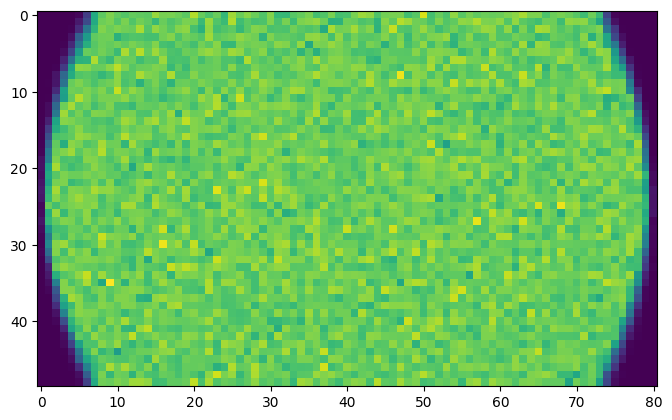

In [109]:
# fig, ax = plt.subplots(1, 2, figsize=(16, 12))
plt.figure(figsize=(8, 6))

grid_cropped = cropp_grid(grid)
grid_offset, N_offset = make_offset(grid_cropped, zc, dz)

eps = 0.2
grid_filter = np.abs(grid_offset / rho_bulk - 0.5) < eps

# plt.imshow(grid_cropped.T)
# plt.imshow(grid_filter.T)
plt.imshow(grid_offset.T)
# grid_cropped
# ax[1].imshow(border.T)
plt.show()

In [110]:
grid_xyz = grid2xyz(grid_filter, dx, dz)

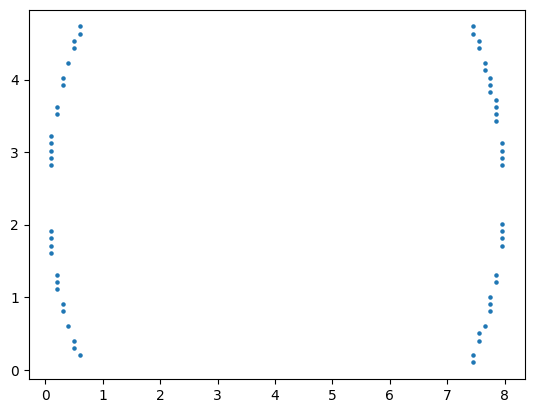

In [111]:
plt.scatter(grid_xyz[:, 0], grid_xyz[:, 1], s=5)

In [112]:
lx, lz = np.max(grid_xyz, axis=0)
left_grid_xyz = grid_xyz[grid_xyz[:, 0] < lx / 2, :]
right_grid_xyz = grid_xyz[grid_xyz[:, 0] > lx / 2, :]

In [113]:
xc_left, zc_left, r_left, sigma_left = taubinSVD(left_grid_xyz)
xc_right, zc_right, r_right, sigma_right = taubinSVD(right_grid_xyz)

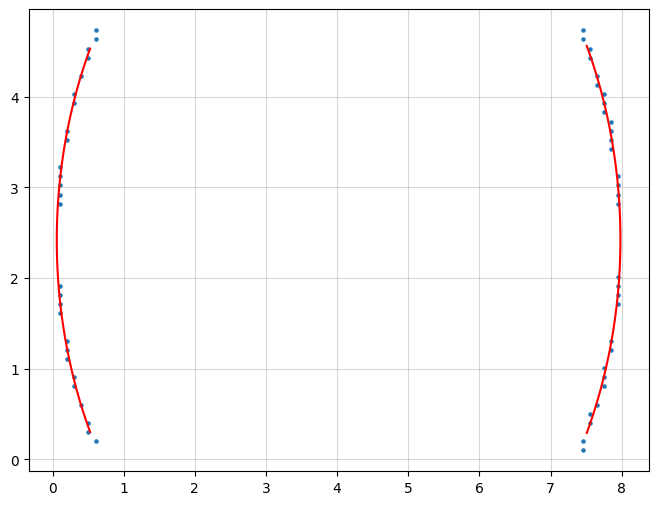

In [114]:
plt.figure(figsize=(8, 6))
plt.grid(alpha=0.5)

plt.scatter(grid_xyz[:, 0], grid_xyz[:, 1], s=5)

angle_left = np.linspace(np.deg2rad(155), np.deg2rad(205), 100)
plt.plot(xc_left + r_left * np.cos(angle_left), zc_left + r_left * np.sin(angle_left), color='red')

angle_right = np.linspace(np.deg2rad(-25), np.deg2rad(25), 100)
plt.plot(xc_right + r_right * np.cos(angle_right), zc_right + r_right * np.sin(angle_right), color='red')

In [115]:
LX, LZ = np.array(grid_cropped.shape) * np.array([dx, dz])
lx, lz = np.array(grid_offset.shape) * np.array([dx, dz])

dz = N_offset * dz

In [100]:
# Without extropolation
x_top_left = -np.sqrt(r_left**2 - (lz - zc_left)**2) + xc_left
angle_top_left = np.pi / 2 + np.arctan(np.abs(lz - zc_left) / np.abs(xc_left - x_top_left))
x_bottom_left = -np.sqrt(r_left**2 - (zc_left)**2) + xc_left
angle_bottom_left = np.pi / 2 + np.arctan(np.abs(zc_left) / np.abs(xc_left - x_bottom_left))

x_top_right = np.sqrt(r_right**2 - (lz - zc_right)**2) + xc_right
angle_top_right = np.pi / 2 + np.arctan(np.abs(lz - zc_right) / np.abs(xc_right - x_top_right))
x_bottom_right = np.sqrt(r_left**2 - (zc_right)**2) + xc_right
angle_bottom_right = np.pi / 2 + np.arctan(np.abs(zc_right) / np.abs(xc_right - x_bottom_right))

In [101]:
print(
    np.rad2deg(angle_bottom_left),
    np.rad2deg(angle_top_left),
    np.rad2deg(angle_top_right),
    np.rad2deg(angle_bottom_right),
    sep='\n'
)

97.08208338761129
97.90077654044639
98.18507566911588
97.28315497026989


In [102]:
print(np.rad2deg(angle_bottom_left + angle_top_left + angle_top_right + angle_bottom_right) / 4)

97.61277264186086


---

In [85]:
plt.rcParams['font.family'] = 'Helvetica'

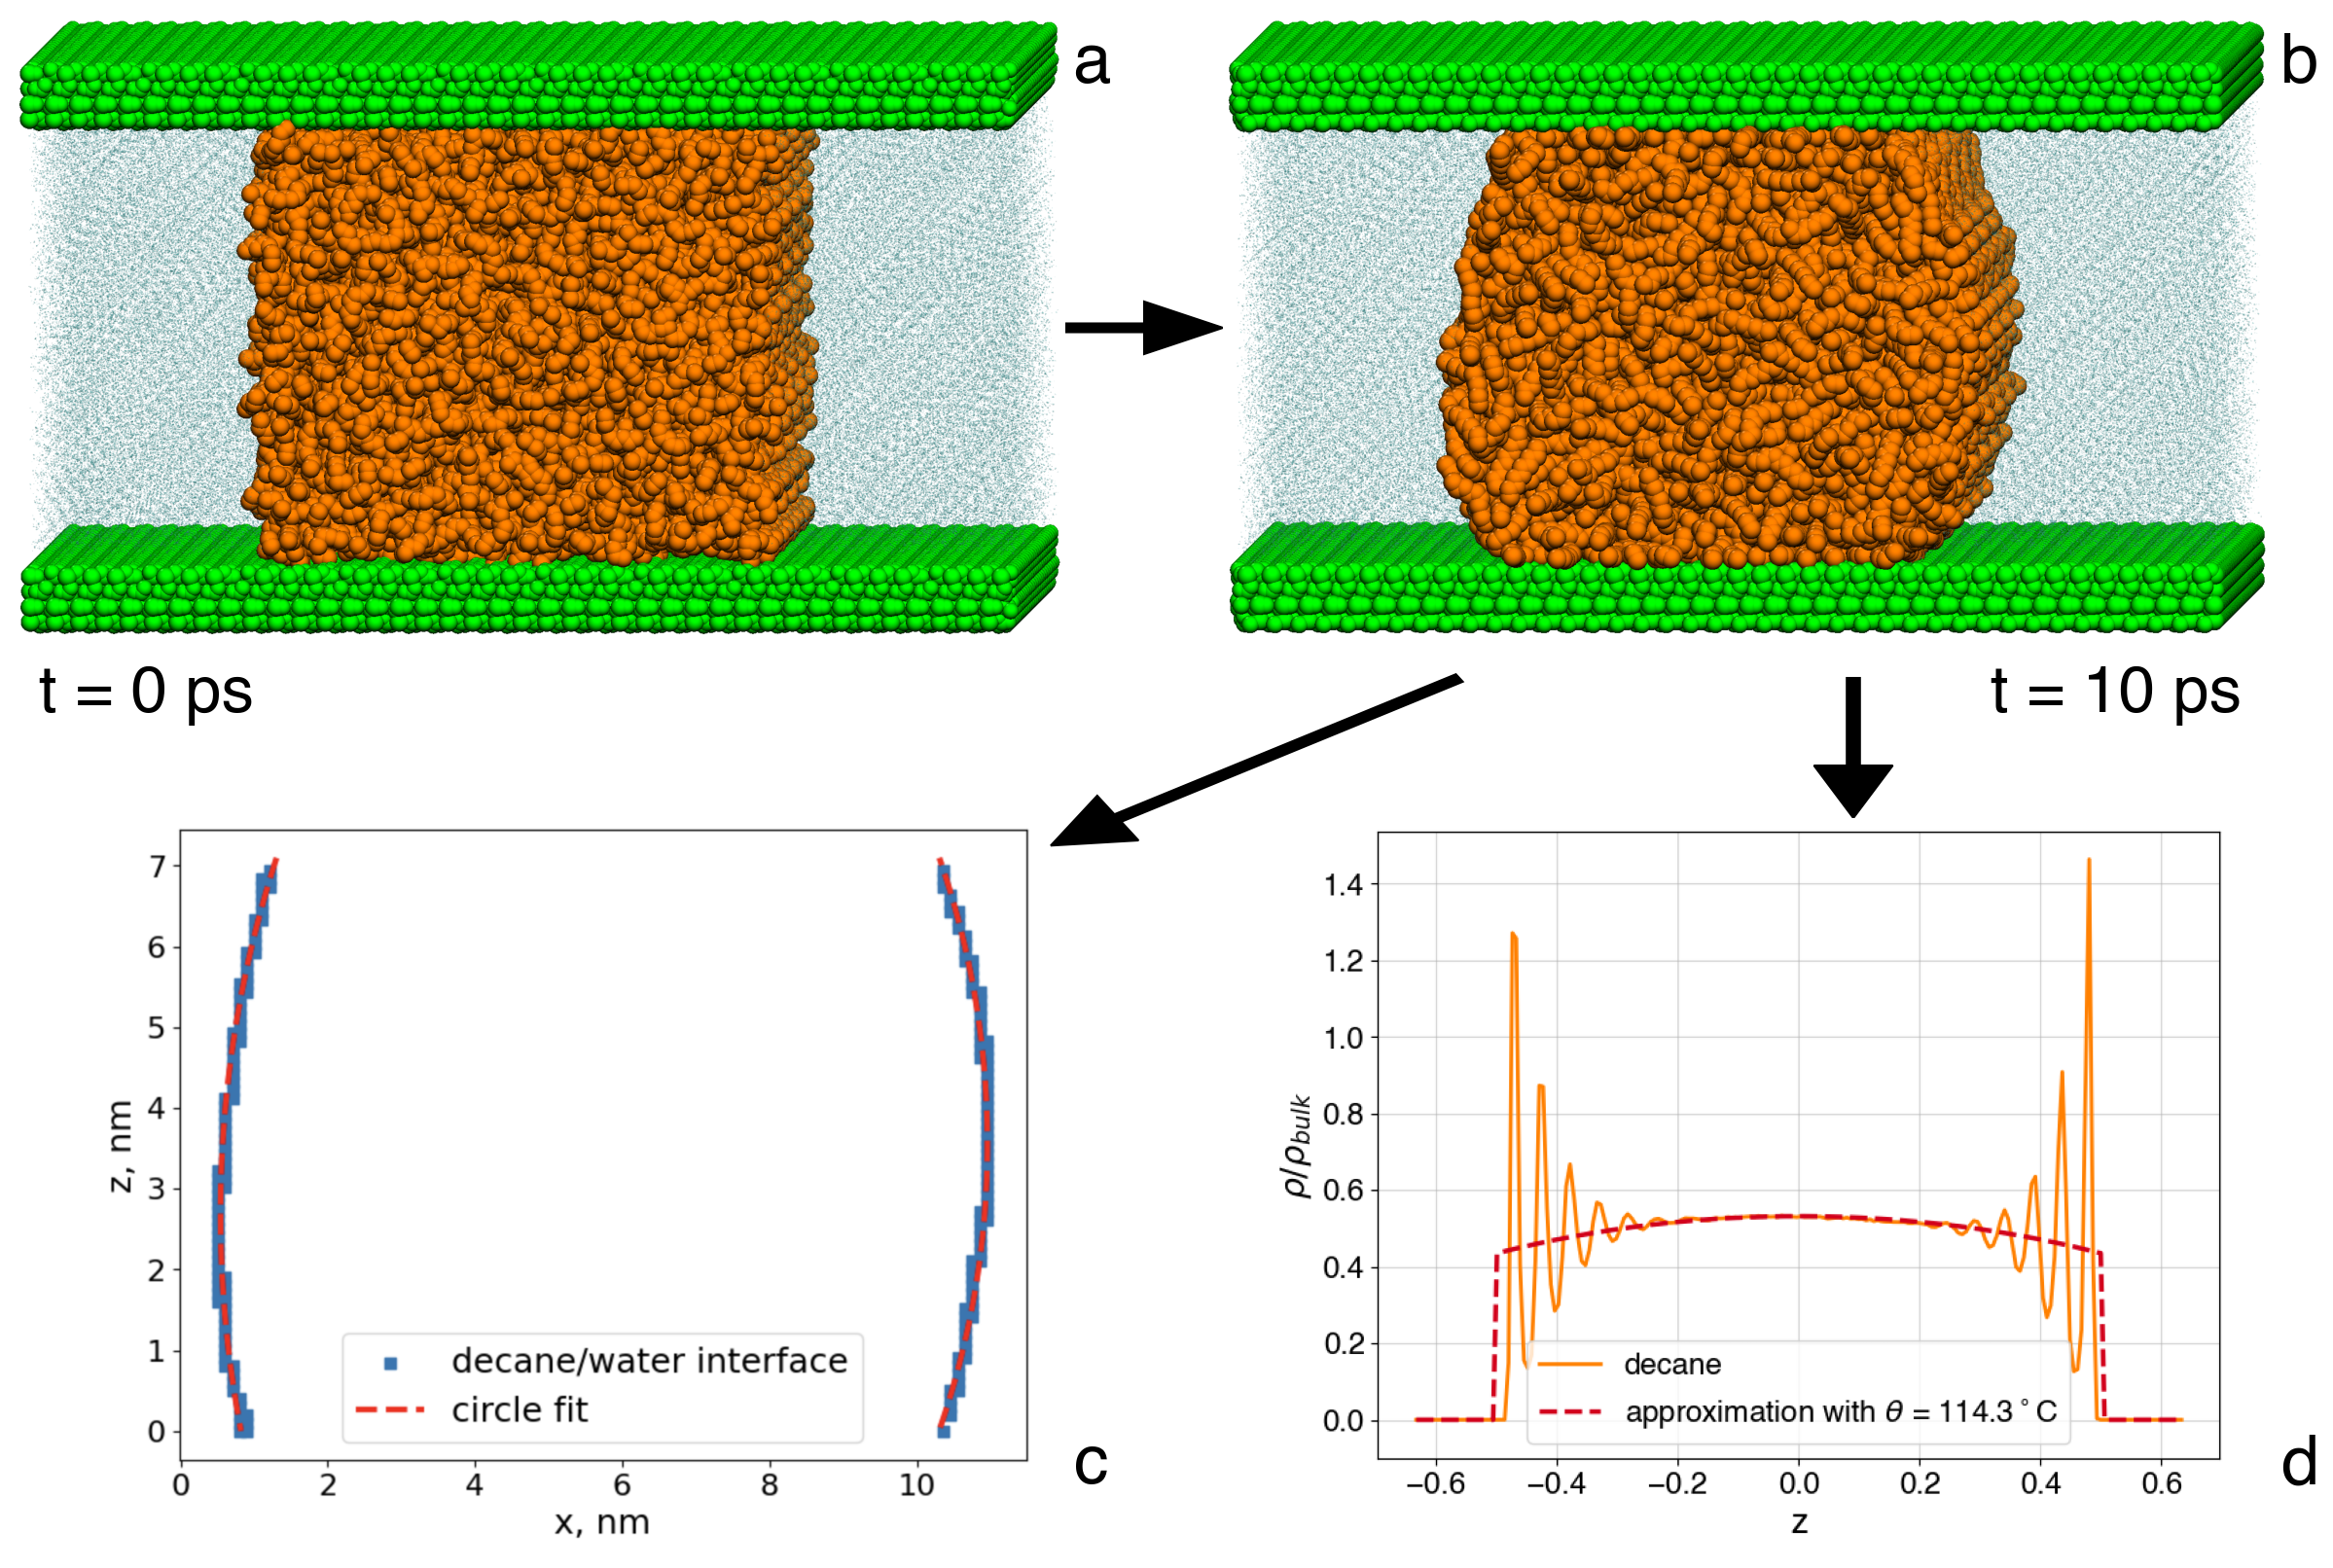

In [132]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the four images
img1 = mpimg.imread('calcite_decane_water_init.png')  # Replace with your first image path
img2 = mpimg.imread('calcite_decane_water.png')  # Replace with your second image path
img3 = mpimg.imread('calcite_decane_water_angle_approx.png')  # Replace with your third image path
img4 = mpimg.imread('calcite_decane_water_profile_approx.png')  # Replace with your fourth image path

# Create a new figure
fig, ax = plt.subplots(figsize=(18, 12), dpi=150)
plt.axis('off')  # Turn off the axis for the main plot as well

# Define positions for the four subplots
positions = [(0.05, 0.55, 0.4, 0.4),  # Top-left image (t = 0 ps)
             (0.51, 0.55, 0.4, 0.4),  # Top-right image (t = 10 ps)
             (0.05, 0.05, 0.42, 0.42),  # Bottom-left plot
             (0.5, 0.05, 0.42, 0.42)]  # Bottom-right plot

# Images to plot
images = [img1, img2, img3, img4]

# Add each image to the figure in the defined positions
for i, (pos, img) in enumerate(zip(positions, images)):
    ax_inset = fig.add_axes(pos)
    ax_inset.imshow(img)
    ax_inset.axis('off')

# Draw arrows
# plt.arrow(0.44, 0.55, 0.05, 0, width=0.001, head_width=0.01, head_length=0.01, fc='black', ec='black')
# plt.arrow(0.32, 0.52, -0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')
# plt.arrow(0.68, 0.52, 0.05, -0.22, width=0.001, head_width=0.03, head_length=0.03, fc='black', ec='black')

ax.arrow(0.4, 0.75, 0.08, 0, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)
ax.arrow(0.6, 0.55, -0.13, -0.08, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)
ax.arrow(0.75, 0.55, 0, -0.05, width=0.005, head_width=0.03, head_length=0.03, fc='black', ec='black', transform=fig.transFigure)

# Add text annotations
ax.text(0.1, 0.54, "t = 0 ps", fontsize=32, ha='center', va='center', transform=fig.transFigure)
ax.text(0.85, 0.54, "t = 10 ps", fontsize=32, ha='center', va='center', transform=fig.transFigure)

# Add labels (a, b, c, d) in the bottom right corner of each image
label_positions = [(0.46, 0.9),  # Bottom-right corner of the top-left image
                   (0.92, 0.9),  # Bottom-right corner of the top-right image
                   (0.46, 0.1),  # Bottom-right corner of the bottom-left image
                   (0.92, 0.1)]  # Bottom-right corner of the bottom-right image

labels = ['a', 'b', 'c', 'd']

# Add each label to the figure
for label, (x, y) in zip(labels, label_positions):
    fig.text(x, y, label, fontsize=34, ha='center', va='center', transform=fig.transFigure, fontweight='bold')


# plt.savefig('steps.png', dpi=150)
plt.show()


In [133]:
0.002 * 20000000

40000.0